In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# Check the shape of the datasets
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)


(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

In [5]:
#Import Libraries

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Load CIFAR-10 Dataset
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
y_train = y_train.reshape(-1, 1)


In [7]:
#Build the Generator

def build_generator():
    noise = layers.Input(shape=(100,))
    label = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(10, 100)(label)
    label_embedding = layers.Flatten()(label_embedding)

    model_input = layers.multiply([noise, label_embedding])

    x = layers.Dense(256)(model_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(32 * 32 * 3, activation='tanh')(x)
    img = layers.Reshape((32, 32, 3))(x)

    return tf.keras.models.Model([noise, label], img)


In [8]:
#Build the Discriminator

def build_discriminator():
    img = layers.Input(shape=(32, 32, 3))
    label = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(10, np.prod((32, 32, 3)))(label)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((32, 32, 3))(label_embedding)

    model_input = layers.multiply([img, label_embedding])

    x = layers.Flatten()(model_input)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    validity = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.models.Model([img, label], validity)


In [9]:
#Compile the Models

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
                      metrics=['accuracy'])

generator = build_generator()
noise = layers.Input(shape=(100,))
label = layers.Input(shape=(1,))
img = generator([noise, label])

discriminator.trainable = False
validity = discriminator([img, label])

combined = tf.keras.models.Model([noise, label], validity)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
#Training the cGAN

def train(epochs, batch_size=128, sample_interval=50):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs, labels = x_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict([noise, labels])

        valid = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        sampled_labels = np.random.randint(0, 10, (batch_size, 1))

        valid = np.ones((batch_size, 1))
        g_loss = combined.train_on_batch([noise, sampled_labels], valid)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")
            sample_images(epoch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7021157741546631, acc.: 25.78125] [G loss: [array(0.699099, dtype=float32), array(0.699099, dtype=float32), array(0.484375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


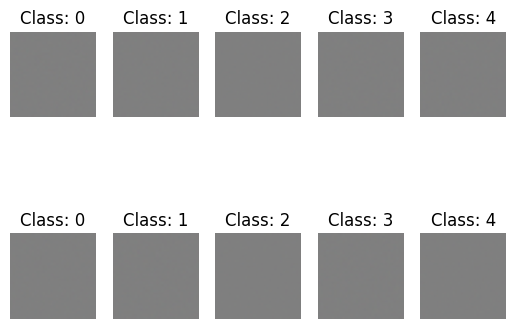

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [11]:
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.array([num for _ in range(r) for num in range(c)])

    gen_imgs = generator.predict([noise, sampled_labels])

    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].set_title(f"Class: {sampled_labels[cnt]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

train(epochs=10, batch_size=64, sample_interval=200)
